In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import LSTM, Dense

# ====== USER-DEFINED FUNCTIONS ====== #

def create_seq2seq_data(df, input_length, output_length, feature_cols, target_col):
    """
    Creates seq2seq input-output arrays:
      - X_enc:  3D array (samples, timesteps, features) for the encoder
      - X_dec:  3D array (samples, timesteps, features) for the decoder
      - Y:      3D array (samples, timesteps, 1) for the target

    df:           DataFrame containing features + target
    input_length: Number of time steps for the encoder input
    output_length:Number of time steps for the decoder output
    feature_cols: List of feature column names
    target_col:   Name of the target column
    """
    data_array = df[feature_cols].values
    target_array = df[target_col].values

    X_enc_list = []
    X_dec_list = []
    Y_list     = []

    # We can feed the previous target values as the decoder input
    # or zeros; this example uses previous target values.
    for i in range(len(df) - input_length - output_length):
        # Encoder input: last 'input_length' timesteps
        X_enc_list.append(data_array[i : i + input_length])

        # Decoder input: last 'output_length' timesteps of the *target*
        # (Here, we create a single feature for the decoder = scaled target)
        decoder_input = target_array[i + input_length - 1 : i + input_length - 1 + output_length]
        # Shift by one so the model sees "previous" target values
        # If you prefer zeros, you can replace it with np.zeros(output_length).
        X_dec_list.append(decoder_input.reshape(-1, 1))

        # Decoder output: next 'output_length' timesteps of target
        Y_list.append(target_array[i + input_length : i + input_length + output_length].reshape(-1, 1))

    # Convert to numpy arrays with shapes:
    # X_enc: (samples, input_length, num_features)
    # X_dec: (samples, output_length, 1)
    # Y:     (samples, output_length, 1)
    return (
        np.array(X_enc_list),
        np.array(X_dec_list),
        np.array(Y_list)
    )

def build_seq2seq_model(input_length, output_length, num_encoder_features, num_decoder_features, lstm_units=64):
    """
    Example seq2seq model with separate encoder & decoder built using LSTM layers.
    For simplicity, we’ll use a single LSTM for encoder, one for decoder.
    """
    from keras.models import Model
    from keras.layers import Input, LSTM, RepeatVector, TimeDistributed

    # ----- Encoder -----
    encoder_inputs = Input(shape=(input_length, num_encoder_features), name="Encoder_Input")
    encoder_lstm = LSTM(lstm_units, return_state=True, name="Encoder_LSTM")
    _, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # ----- Decoder -----
    decoder_inputs = Input(shape=(output_length, num_decoder_features), name="Decoder_Input")
    decoder_lstm = LSTM(lstm_units, return_sequences=True, name="Decoder_LSTM")
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    # Final Dense to produce 1 value per timestep
    decoder_dense = TimeDistributed(Dense(1), name="Output_Dense")
    decoder_outputs = decoder_dense(decoder_outputs)

    # ----- Build Model -----
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

# ====== MAIN SCRIPT ====== #

# Common parameters
TARGET_COL      = "loadConsumption"
INPUT_LENGTH    = 30   # Lookback window
TEST_RATIO      = 0.2
EPOCHS          = 20
BATCH_SIZE      = 16

# Forecast horizons to test
HORIZONS = [1, 7, 30, 90, 180]

# Example feature sets (update as needed)
feature_sets = {
    "Exogenous Features": [
        'DailyMeanTemperature', 'DailyMeanWindspeed', 'DailyPrecipitation', 'day_of_week',
        'AveragePrice_Electricity_Household', 'AveragePrice_NaturalGas_Household',
        'Economic_Component', 'RenewableEnergy_Component'
    ],
    "Generated Features": [
        'is_weekend', 'is_holiday', 'day_of_year',
        'rolling_7', 'rolling_30', 'rolling_365'
    ],
    "Both Exogenous & Generated": [
        'DailyMeanTemperature', 'DailyMeanWindspeed', 'DailyPrecipitation', 'day_of_week',
        'AveragePrice_Electricity_Household', 'AveragePrice_NaturalGas_Household',
        'Economic_Component', 'RenewableEnergy_Component',
        'is_weekend', 'is_holiday', 'day_of_year',
        'rolling_7', 'rolling_30', 'rolling_365'
    ]
}

# 1) Load your dataset
df_models = pd.read_csv("temp.csv")  # Replace with your CSV file

# We'll collect final results here
results_list = []

# 2) Iterate over each feature set and horizon
for fs_name, fs_columns in feature_sets.items():
    for horizon in HORIZONS:
        print(f"\n=== Seq2Seq Model for Feature Set: {fs_name}, Horizon: {horizon} ===")
        
        # Subset DataFrame to selected features + target
        use_cols = fs_columns + [TARGET_COL]
        temp_df = df_models[use_cols].copy()
        
        # Train/Test Split in the original time order
        split_index = int(len(temp_df) * (1 - TEST_RATIO))
        df_train = temp_df.iloc[:split_index].copy()
        df_test  = temp_df.iloc[split_index:].copy()
        
        # Scale Data
        scaler_features = MinMaxScaler()
        scaler_target   = MinMaxScaler()
        
        # Fit on train
        df_train[fs_columns] = scaler_features.fit_transform(df_train[fs_columns])
        df_test[fs_columns]  = scaler_features.transform(df_test[fs_columns])
        
        df_train[[TARGET_COL]] = scaler_target.fit_transform(df_train[[TARGET_COL]])
        df_test[[TARGET_COL]]  = scaler_target.transform(df_test[[TARGET_COL]])
        
        # Create Seq2Seq Datasets
        X_enc_train, X_dec_train, Y_train = create_seq2seq_data(
            df_train,
            input_length=INPUT_LENGTH,
            output_length=horizon,
            feature_cols=fs_columns,
            target_col=TARGET_COL
        )
        X_enc_test, X_dec_test, Y_test = create_seq2seq_data(
            df_test,
            input_length=INPUT_LENGTH,
            output_length=horizon,
            feature_cols=fs_columns,
            target_col=TARGET_COL
        )
        
        # If there's not enough data to form sequences, skip
        if X_enc_train.shape[0] == 0 or X_enc_test.shape[0] == 0:
            print("Not enough data to create sequences. Skipping.")
            results_list.append({
                "Feature Set": fs_name,
                "Horizon": horizon,
                "MSE":  np.nan,
                "RMSE": np.nan,
                "MAE":  np.nan,
                "MAPE": np.nan
            })
            continue
        
        num_encoder_features = len(fs_columns)
        num_decoder_features = 1  # we feed the scaled target to the decoder
        
        # Build Seq2Seq Model for the current horizon
        model_seq2seq = build_seq2seq_model(
            input_length=INPUT_LENGTH,
            output_length=horizon,
            num_encoder_features=num_encoder_features,
            num_decoder_features=num_decoder_features,
            lstm_units=64
        )
        
        # Train the model
        model_seq2seq.fit(
            [X_enc_train, X_dec_train],
            Y_train,
            validation_data=([X_enc_test, X_dec_test], Y_test),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=1
        )
        
        # Predict on the test sequences
        Y_pred_test = model_seq2seq.predict([X_enc_test, X_dec_test])
        # Y_pred_test shape = (num_samples, horizon, 1)
        
        # Flatten predictions across all samples/timesteps
        Y_pred_test_reshaped = Y_pred_test.reshape(-1, 1)
        Y_test_reshaped      = Y_test.reshape(-1, 1)
        
        # Inverse transform
        Y_pred_inversed = scaler_target.inverse_transform(Y_pred_test_reshaped)
        Y_test_inversed = scaler_target.inverse_transform(Y_test_reshaped)
        
        # Compute error metrics
        mse_value  = mean_squared_error(Y_test_inversed, Y_pred_inversed)
        rmse_value = np.sqrt(mse_value)
        mae_value  = mean_absolute_error(Y_test_inversed, Y_pred_inversed)
        # Avoid division by zero with 1e-9
        mape_value = np.mean(np.abs((Y_test_inversed - Y_pred_inversed) / (Y_test_inversed + 1e-9))) * 100
        
        results_list.append({
            "Feature Set": fs_name,
            "Horizon": horizon,
            "MSE":  mse_value,
            "RMSE": rmse_value,
            "MAE":  mae_value,
            "MAPE": mape_value
        })

# 3) Create a DataFrame of results
results_df = pd.DataFrame(results_list)
print("\n===== Seq2Seq Forecasting Results (Multiple Horizons) =====")
print(results_df[["Feature Set", "Horizon", "MSE", "RMSE", "MAE", "MAPE"]])


=== Seq2Seq Model for Feature Set: Exogenous Features, Horizon: 1 ===
Epoch 1/20
163/163 [==============================] - 7s 22ms/step - loss: 0.0350 - val_loss: 0.0797
Epoch 2/20
163/163 [==============================] - 3s 18ms/step - loss: 0.0187 - val_loss: 0.0615
Epoch 3/20
163/163 [==============================] - 3s 19ms/step - loss: 0.0121 - val_loss: 0.0564
Epoch 4/20
163/163 [==============================] - 3s 17ms/step - loss: 0.0092 - val_loss: 0.0381
Epoch 5/20
163/163 [==============================] - 3s 18ms/step - loss: 0.0068 - val_loss: 0.0217
Epoch 6/20
163/163 [==============================] - 3s 17ms/step - loss: 0.0048 - val_loss: 0.0090
Epoch 7/20
163/163 [==============================] - 3s 17ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 8/20
163/163 [==============================] - 3s 17ms/step - loss: 0.0046 - val_loss: 0.0129
Epoch 9/20
163/163 [==============================] - 3s 17ms/step - loss: 0.0041 - val_loss: 0.0152
Epoch 10/20
163/163 

In [2]:
results_df

,Feature Set,Horizon,MSE,RMSE,MAE,MAPE
0,Exogenous Features,1,2.339715e+08,15296.127816,11762.997212,4.257789
1,Exogenous Features,7,1.907787e+08,13812.264775,10463.553103,3.776805
2,Exogenous Features,30,3.008361e+08,17344.627350,13349.159827,4.720943
3,Exogenous Features,90,1.883423e+08,13723.787488,10406.467788,3.738563
4,Exogenous Features,180,1.990203e+08,14107.454502,10354.735741,3.733680
5,Generated Features,1,1.353617e+08,11634.504061,8959.277178,3.201587
6,Generated Features,7,1.374175e+08,11722.519097,9144.515210,3.248516
7,Generated Features,30,1.308267e+08,11437.948744,8842.764571,3.137905
8,Generated Features,90,1.201827e+08,10962.785144,8357.736895,3.002568
9,Generated Features,180,1.193153e+08,10923.153144,8206.117080,2.935990


In [5]:
mean_load = df_models["loadConsumption"].mean()  

In [6]:
results_df["nRMSE"] = results_df["RMSE"] / mean_load
results_df["nMAE"] = results_df["MAE"] / mean_load

In [8]:
results_df["nRMSE (%)"] = results_df["nRMSE"] * 100
results_df["nMAE (%)"] = results_df["nMAE"] * 100

In [2]:
results_df.to_csv('resultsSeq2Seq.csv', index = False)

NameError: name 'results_df' is not defined

In [11]:
results_df[results_df["Horizon"] == 180]

,Feature Set,Horizon,MSE,RMSE,MAE,MAPE,nRMSE,nMAE,nRMSE (%),nMAE (%)
4,Exogenous Features,180,1.990203e+08,14107.454502,10354.735741,3.733680,0.046496,0.034128,4.649609,3.412768
9,Generated Features,180,1.193153e+08,10923.153144,8206.117080,2.935990,0.036001,0.027046,3.600110,2.704615
14,Both Exogenous & Generated,180,1.392804e+08,11801.713363,8797.429780,3.134638,0.038897,0.028995,3.889670,2.899503


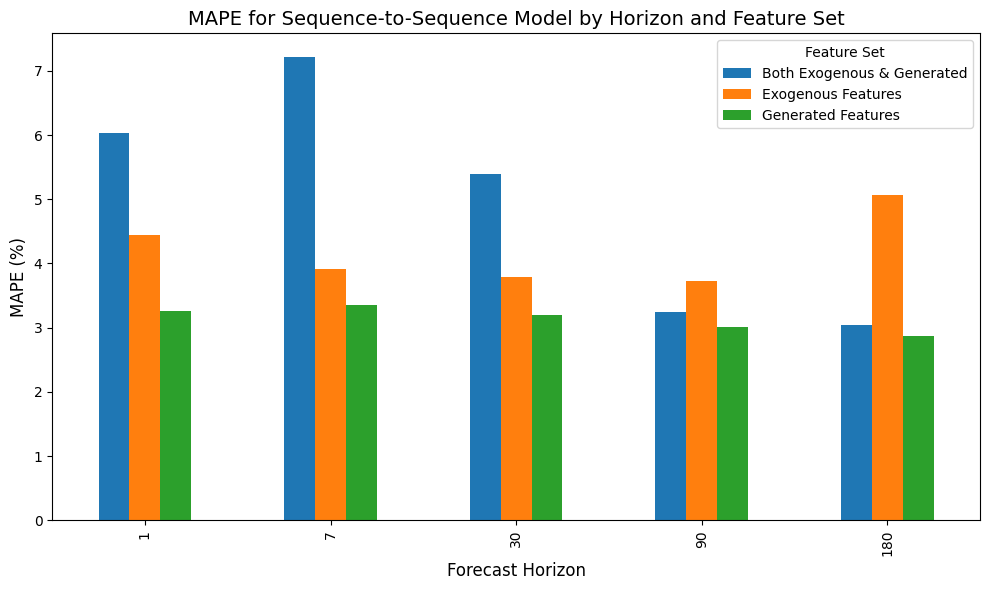

In [6]:
import matplotlib.pyplot as plt

# Assuming results_df is the DataFrame containing the results with columns:
# "Feature Set", "Horizon", and "MAPE"
# For instance, results_df could look like:
#   Feature Set   Horizon    MAPE
# 0  Exogenous Features   1   12.5
# 1  Exogenous Features   7   15.3
# ...

# Pivot the DataFrame to have forecast horizons as the index and feature sets as columns
pivot_data = results_df.pivot(index="Horizon", columns="Feature Set", values="MAPE")

# Create a grouped bar chart
ax = pivot_data.plot(kind="bar", figsize=(10, 6))
ax.set_title("MAPE for Sequence-to-Sequence Model by Horizon and Feature Set", fontsize=14)
ax.set_xlabel("Forecast Horizon", fontsize=12)
ax.set_ylabel("MAPE (%)", fontsize=12)
plt.legend(title="Feature Set", fontsize=10)
plt.tight_layout()
plt.show()